In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


In [2]:
from functools import partial

from tqdm import tqdm

import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

from jax import jit, vmap, grad

from bpd.prior import sample_ellip_prior, shear_transformation, ellip_mag_prior
from bpd.likelihood import shear_loglikelihood
from bpd.pipelines.toy_ellips import pipeline_toy_ellips_samples


## Fisher and likelihood

In [3]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

2024-12-03 04:44:33.866694: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
seed = 42
key = random.key(seed)
k1, k2 = random.split(key, 2)

In [5]:
sigma_e=1e-3
sigma_e_int = 4e-2

In [7]:
pipe = jit(partial(pipeline_toy_ellips_samples, g1=g1, g2 = g2, sigma_e=sigma_e, sigma_e_int=sigma_e_int, sigma_m=1e-5, n_gals=1000, 
                    n_samples_per_gal=100, )
           )

In [8]:
e_post, e_obs, e_sheared = pipe(k1)

In [11]:
# compare std deviations 
e_sheared[:, 0].std(), e_obs[:,0].std(), e_post[:, :, 0].std(), sigma_e / jnp.sqrt(2)

(Array(0.00073002, dtype=float64),
 Array(0.00072945, dtype=float64),
 Array(0.0007295, dtype=float64),
 Array(0.00070711, dtype=float64, weak_type=True))

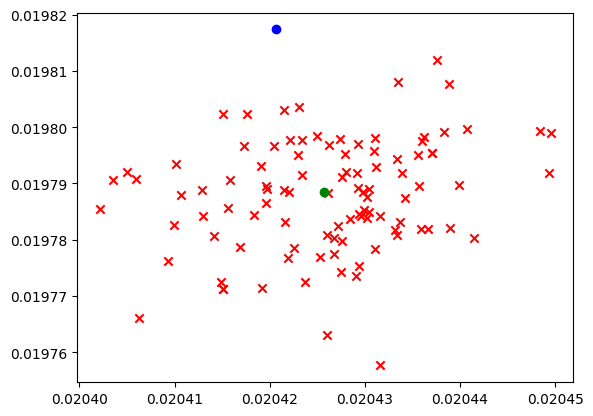

In [13]:
# example (sanity check)
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], marker='x', color='r')
plt.scatter(e_obs[0, 0], e_obs[0, 1], marker='o', color='g')
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], marker='o', color='b')

In [15]:
prior = ellip_mag_prior
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)
_likelihood = jit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior, sigma_e=sigma_e))
likelihood = lambda g, e_post: _likelihood(g, e_post=e_post)

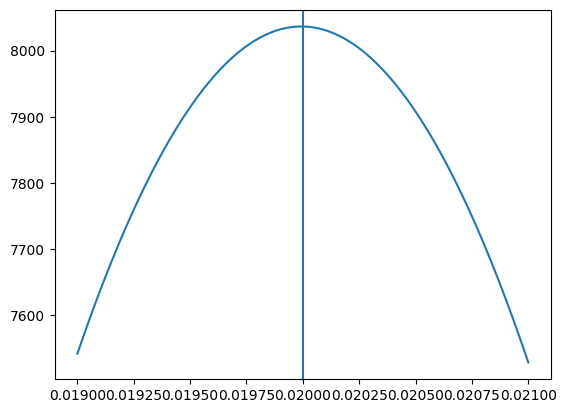

In [16]:
# sanity check
g1s = jnp.linspace(0.019, 0.021, 1000)
gs = jnp.stack([g1s, jnp.full_like(g1s, g2)], axis=-1)
plt.plot(g1s, vmap(likelihood, in_axes=(0, None))(gs, e_post))
plt.axvline(0.02)

In [17]:
# test we can do gradients
grad(likelihood)(true_g, e_post)

Array([ -6663.44839376, -21045.23239405], dtype=float64)

In [34]:
# optax to find maximum point

In [35]:
# get error via Fisher information matrix
grad1 = lambda g, e: grad(likelihood)(g, e)[0]
grad2 = lambda g, e: grad(likelihood)(g, e)[1]

In [36]:
i11, i12 = - grad(grad1)(true_g, e_post)
i21, i22 = - grad(grad2)(true_g, e_post)

In [37]:
inf_mat = jnp.array([[i11, i12], [i21, i22]])
cov = jnp.linalg.inv(inf_mat)

In [38]:
inf_mat, cov

(Array([[1.00150753e+09, 4.93783690e-01],
        [4.93783691e-01, 1.00150995e+09]], dtype=float64),
 Array([[ 9.98494743e-10, -4.92297073e-19],
        [-4.92297074e-19,  9.98492322e-10]], dtype=float64))

In [39]:
1e-3 / jnp.sqrt(1000), jnp.sqrt(cov[0][0]), jnp.sqrt(cov[1][1]), 

(Array(3.16227766e-05, dtype=float64, weak_type=True),
 Array(3.15989674e-05, dtype=float64),
 Array(3.15989291e-05, dtype=float64))

### Plot as a function of number of galaxies

In [73]:
def get_fisher_cov(e_post, true_g, likelihood_fnc):
    grad1 = lambda g:grad(likelihood_fnc)(g, e_post=e_post)[0]
    grad2 = lambda g: grad(likelihood_fnc)(g, e_post=e_post)[1]
    i11, i12 = - grad(grad1)(true_g)
    i21, i22 = - grad(grad2)(true_g)
    inf_mat = jnp.array([[i11, i12], [i21, i22]])
    cov = jnp.linalg.inv(inf_mat)
    return cov

In [74]:
seed = 42
key = random.key(seed)
k1, k2 = random.split(key, 2)


In [75]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

In [76]:
sigma_e=1e-3
sigma_e_int = 4e-2
sigma_m = 1e-5

In [77]:
pipe = jit(partial(pipeline_toy_ellips_samples, g1=g1, g2 = g2, 
                    sigma_e=sigma_e, 
                    sigma_e_int=sigma_e_int, 
                    sigma_m=sigma_m, 
                    n_gals=100_000, 
                    n_samples_per_gal=100, 
                   )
           )
e_post, e_obs, e_sheared = pipe(k1)

In [78]:
covs = []

prior = ellip_mag_prior
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)
likelihood_fnc = jit(partial(shear_loglikelihood, sigma_e=sigma_e, prior=prior, interim_prior=interim_prior)) 

n_galaxies = (1, 10, 100, 1000, 10_000, 100_000)

for ii in tqdm(n_galaxies):
    e_samples = e_post[:ii]
    cov = get_fisher_cov(e_samples, true_g, likelihood_fnc)
    covs.append(cov)
    

100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


In [79]:
# what is actual std of first component?
from bpd.prior import sample_ellip_prior
ellips_unsheared = sample_ellip_prior(k1, sigma=sigma_e, n=100_000)
ellips_unsheared[:, 0].std(), 1e-3 / jnp.sqrt(2)

(Array(0.00070658, dtype=float64),
 Array(0.00070711, dtype=float64, weak_type=True))

Text(0, 0.5, 'Sigma on g1')

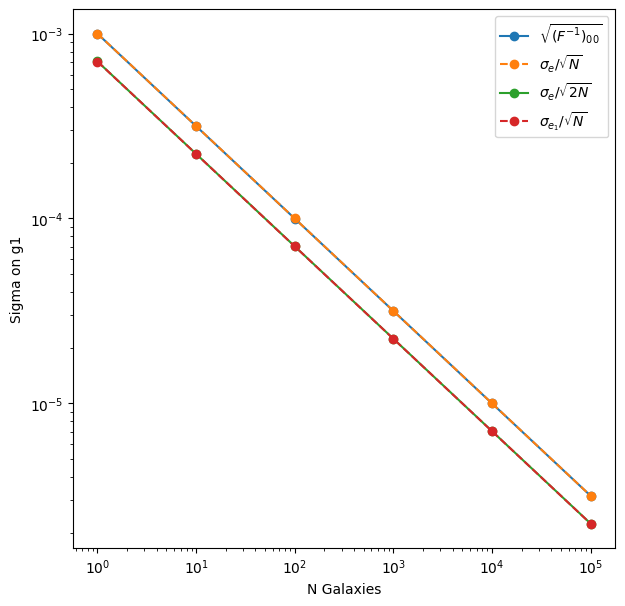

In [80]:
plt.figure(figsize=(7,7))
stds = [jnp.sqrt(cov[0][0]) for cov in covs]


plt.plot(n_galaxies, stds, '-o', label='$\sqrt{(F^{-1})_{00}}$')
plt.plot(n_galaxies, sigma_e / jnp.sqrt(jnp.array(n_galaxies)), '--o', label='$\sigma_{e} / \sqrt{N}$')
plt.xscale('log')

plt.plot(n_galaxies, sigma_e / jnp.sqrt(2 * jnp.array(n_galaxies)), '-o', label='$\sigma_{e} / \sqrt{2N}$')
plt.plot(n_galaxies, ellips_unsheared[:, 0].std() / jnp.sqrt(jnp.array(n_galaxies)), '--o', label='$\sigma_{e_{1}} / \sqrt{N}$')
# plt.plot(n_galaxies, jnp.sqrt(e_sheared[:, 0]**2 + e_sheared[:,1]**2).std() * jnp.sqrt(2) / jnp.sqrt(jnp.array(n_galaxies)), '-.o', label='$\sigma_{e^{s}} \sqrt{2}/ \sqrt{N}$')


plt.yscale('log')
plt.legend()
plt.xlabel("N Galaxies")
plt.ylabel("Sigma on g1")

Text(0, 0.5, 'Absolute fractional difference')

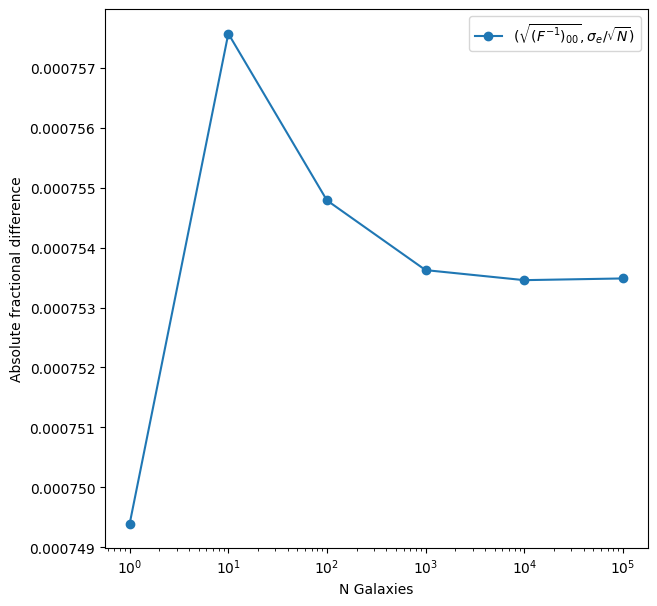

In [81]:
plt.figure(figsize=(7,7))
stds = [jnp.sqrt(cov[0][0]) for cov in covs]

std1 = jnp.array(stds)
std2 = sigma_e / jnp.sqrt(jnp.array(n_galaxies))
res = jnp.abs((std1 - std2) / std2)

plt.plot(n_galaxies, res, '-o', label='$(\sqrt{(F^{-1})_{00}}, \sigma_{e} / \sqrt{N})$')
plt.xscale('log')


plt.legend()
plt.xlabel("N Galaxies")
plt.ylabel("Absolute fractional difference")

In [87]:
# likelihood_fnc = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 
grad_likelihood = lambda g, e: grad(likelihood_fnc)(g, e_post=e)

In [88]:
# what about mean prediction
import optax
from optax import adam

peak_gs = []

for ii in tqdm(n_galaxies):

    solver = adam(learning_rate=0.003)
    # params = {'g': jnp.array([0.019, 0.019])}
    curr_g = jnp.array([0.019, 0.019])
    opt_state = solver.init(curr_g)


    for _ in range(1000):
        grad_val = -grad_likelihood(curr_g, e_post[:ii])
        updates, opt_state = solver.update(grad_val, opt_state, curr_g)
        curr_g = optax.apply_updates(curr_g, updates)
        
    peak_gs.append(curr_g)
    
    


100%|██████████| 6/6 [00:40<00:00,  6.70s/it]


In [89]:
peak_gs = jnp.array(peak_gs)

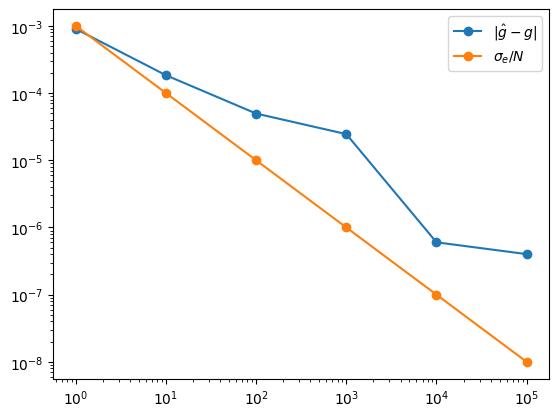

In [97]:
plt.plot(n_galaxies, jnp.abs(peak_gs[:, 0] - 0.02), '-o', label="$|\hat{g} - g|$")
plt.plot(n_galaxies, sigma_e/ jnp.array(n_galaxies), '-o', label="$\sigma_e / N$")
plt.xscale('log')
plt.yscale("log")
plt.legend()

## Sanity check scatter of magnitude after shear

In [17]:
# sanity check magnitude scatter
from bpd.prior import sample_ellip_prior, shear_transformation, sample_mag_ellip_prior
k1 = random.key(42)
g1 = 0.02
sigma_e = 1e-3
e_samples = sample_ellip_prior(k1, sigma=sigma_e, n=100_000)
e_sheared = shear_transformation(e_samples, jnp.array([g1, 0.]))

ep_mag = jnp.sqrt(e_sheared[:, 0]**2 + e_sheared[:, 1]**2)
e_mag = jnp.sqrt(e_samples[:, 0]**2 + e_samples[:, 1]**2)

ep_mag.std(), e_mag.std(), sigma_e

(Array(0.00070613, dtype=float64), Array(0.00060315, dtype=float64), 0.001)

In [18]:
e_sheared[:, 0].std(), e_samples[:, 0].std(), e_mag.std()

(Array(0.00070637, dtype=float64),
 Array(0.00070665, dtype=float64),
 Array(0.00060315, dtype=float64))

In [ ]:
# error on mean shear? 

## Test no noise

**Note:** Does not work

In [ ]:
g1, g2 = 0.02, 0.02
true_g = jnp.array([g1, g2])

In [ ]:
seed = 42
key = random.key(seed)
k1, k2 = random.split(key, 2)

In [ ]:
sigma_e=1e-3
sigma_e_int = 4e-2

In [76]:
ellips = sample_ellip_prior(key, sigma=sigma_e, n=1000)
ellips_sheared = shear_transformation(ellips, (g1, g2))
ellips.shape, ellips_sheared.shape

((1000, 2), (1000, 2))

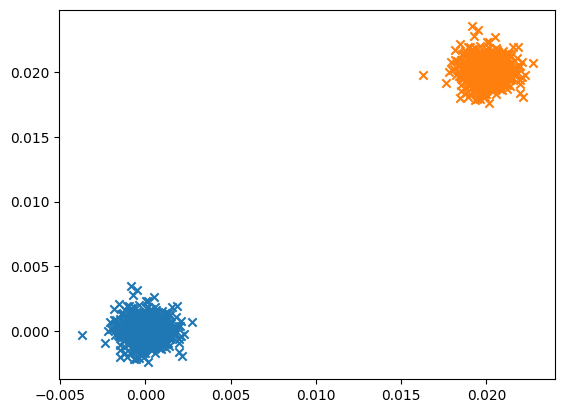

In [77]:
plt.scatter(ellips[:, 0], ellips[:, 1], marker='x')
plt.scatter(ellips_sheared[:, 0], ellips_sheared[:, 1], marker='x')

In [78]:
# # here we assume no observation noise, only 1 sample is needed
# e_post = ellips_sheared.reshape(-1, 1, 2)
# e_post.shape

(1000, 1, 2)

In [79]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e_int)

In [80]:
# NOTE: what does it mean to use an interim prior when we don't infer from it? 
likelihood = jjit(partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)) 

In [81]:
# compile
likelihood(true_g, e_post)

Array(-218.62124169, dtype=float64)

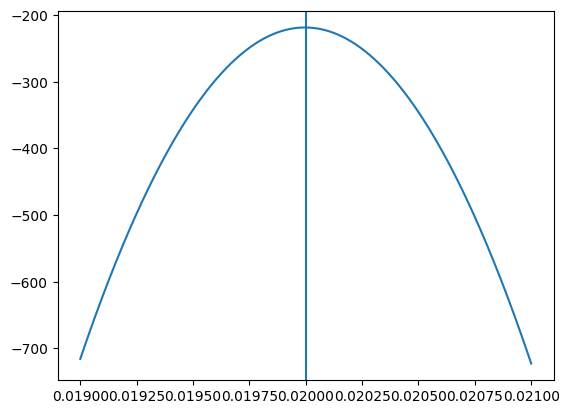

In [82]:
g1s = jnp.linspace(0.019, 0.021, 1000)
gs = jnp.stack([g1s, jnp.full_like(g1s, g2)], axis=-1)
plt.plot(g1s, vmap(likelihood, in_axes=(0, None))(gs, e_post))
plt.axvline(0.02)

In [105]:
likelihood(true_g, e_post)

Array(-218.62124169, dtype=float64)

In [ ]:
# find optimum function using optax

In [98]:
# calculate fisher information matrix to compute std error estimated
grad1 = lambda g, e: grad(likelihood)(g, e)[0]
grad2 = lambda g, e: grad(likelihood)(g, e)[1]

In [103]:
grad(grad1)(jnp.array([0.02, 0.02]), e_post)

Array([nan, nan], dtype=float64)

In [104]:
grad1(true_g, e_post)

Array(nan, dtype=float64)